In [1]:
#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)




     |████████████████████████████████| 591.8 MB 670 bytes/s 
     |████████████████████████████████| 23.3 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.5 MB/s 
     |████████████████████████████████| 22.1 MB 63.2 MB/s 
     |████████████████████████████████| 22.1 MB 53.6 MB/s 
     |████████████████████████████████| 17.4 MB 129 kB/s 
     |████████████████████████████████| 17.3 MB 29.5 MB/s 
     |████████████████████████████████| 12.8 MB 58.8 MB/s 
     |████████████████████████████████| 12.7 MB 24.9 MB/s 
     |████████████████████████████████| 11.8 MB 26.7 MB/s 
     |████████████████████████████████| 5.9 MB 18.3 MB/s 
     |████████████████████████████████| 6.6 MB 25.4 MB/s 
     |████████████████████████████████| 6.6 MB 23.8 MB/s 
     |████████████████████████████████| 4.0 MB 27.2 MB/s 
     |████████████████████████████████| 10.2 MB 18.3 MB/s 
     |████████████████████████████████| 10.1 MB 31.2 MB/s 
     |████████████████████████████████| 8.8 MB 28.4 MB/s 
  

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

In [3]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

In [4]:
batch_size=128 #배치사이즈는 128개이다.
train_dataset=datasets.MNIST('./data', train= True, download= True,transform=transform)
test_dataset=datasets.MNIST('./data', train=False, download=True, transform= transform)

train_dataset, val_dataset=torch.utils.data.random_split(train_dataset, [50000,10000])

train_loader= torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

9920512it [00:00, 71513154.96it/s]                             

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 1134705.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 22176143.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 304661.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
50000 10000 10000


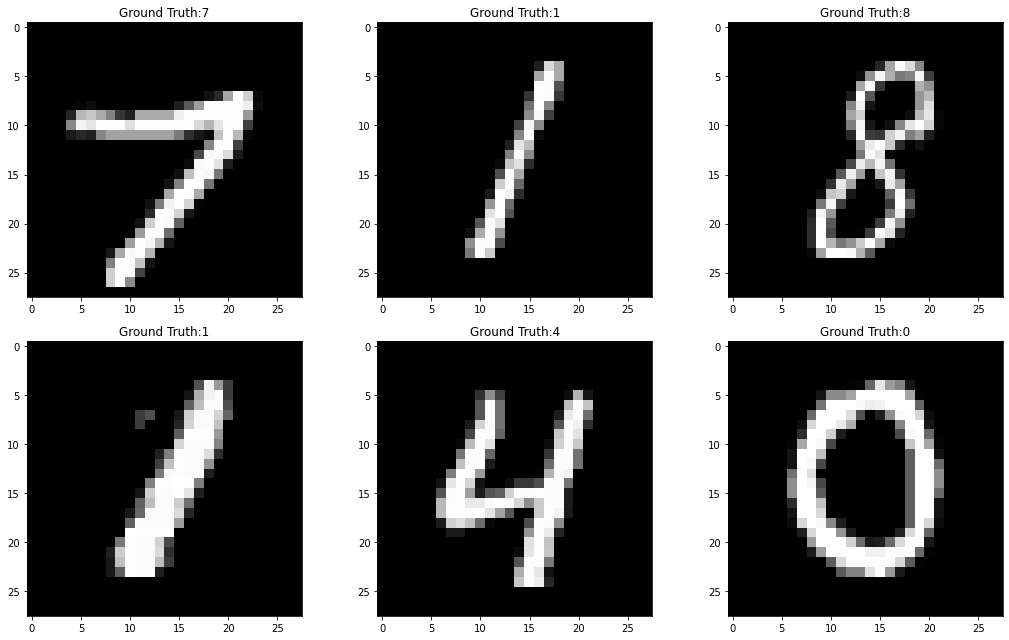

In [5]:
example_data, example_targets=next(iter(train_loader))
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='None')
  #i는 배치를 의미한다. 그리고 [0]인 이유는 MNIST는 3차원이지만 흑백이라서 깊이가 1밖에 없다.
  #배치와 사진의 깊이에 접속한 다음, 가로와 세로를 이용해 그림을 그린다는 뜻이다.
  plt.title('Ground Truth:{}'.format(example_targets[i]))

In [6]:
example_data[0][0].size()

torch.Size([28, 28])

2. Model Architecture

In [7]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.linear1=nn.Linear(784,10)
  def forward(self,x):
    x1 = torch.flatten(x,start_dim=1) # 배치 사이즈까지는 크기를 유지해야 하기 때문에 start_dim을 설정해야 한다.
    lin1=self.linear1(x1)
    return lin1
#1층 다층 퍼셉트론 생성

3. Cost Function Define (Loss Function Define)

In [8]:
cls_loss = nn.CrossEntropyLoss()
cls_loss

CrossEntropyLoss()

4. Train & Evaluation

In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model=LinearModel()
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
#모델의 파라미터를 셀수 있다.

lr=0.005 #학습속도 설정
optimizer=optim.SGD(model.parameters(),lr=lr) #스토캐스틱그래디언트 설정
optimizer
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = [] #시각화를 위한 빈 리스트 생성 

epoch=30
for i in range(epoch):
  train_loss=0
  model.train()
  
  for input_X, true_y in train_loader:

    # 입력 데이터 처리
    input_X=input_X.squeeze(dim=1)
    
    optimizer.zero_grad()
    pred_y=model(input_X)
    #([128, 10])의 형태로 출력된다. 배치사이즈, 카테고리에 속할 정도를 출력한다.
    loss=cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.detach().numpy()   
    #학습 도중:1. 먼저 최적화의 연산 그래프를 초기화 한다.
    #2. 모델을 넣고 연산을 수행후 출력을 내보낸 다음, 정답과 비교를 하여 목적함수 값을 내보낸다.
    #3. 미분 값loss를 앞으로 전달한다.(오류역전파)
    #4. 최적화를 수행한다. 
    #5. 오류연산량에서 텐서를 분리한다음 넘파이로 반환하여 train_loss에 누적한다.
  train_loss = train_loss / len(train_loader) #학습이 끝난 뒤, 누적된 train_loss에서 traindataset의 길이만큼 나눠서 평균 train)loss를 구한다.
  list_train_loss.append(train_loss)#구한 loss를 list_train_loss에 저장한다.
  list_epoch.append(i)
  val_loss = 0
  model.eval()

    
  with torch.no_grad(): #검증과 시험은 오류역전파를 내보내면 안되서 with torch.no_grad()사용
    for input_X, true_y in val_loader:
        # ------------------빈 칸------------------#
        # 입력 데이터 처리
      input_X=input_X.squeeze(dim=1) #배치사이즈는 남겨야하기 때문에 (1, 1, 28, 28)중 rgb차원 1을 없애기
        
        # -----------------------------------------#
      pred_y = model(input_X)

      loss = cls_loss(pred_y.squeeze(), true_y)
      val_loss += loss.detach().numpy()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)



  correct = 0
  model.eval()

  with torch.no_grad():
    for input_X, true_y in test_loader:
        # ------------------빈 칸------------------#
        # 입력 데이터 처리

      input_X=input_X.squeeze(dim=1)
      
      # 모델 출력 결과를 이용하여 모델이 이미지를 제대로 맞춘 개수를 출력하는 correct를 구현하세요
      pred_y = model(input_X)
      _,predicted= torch.max(pred_y,1) #128 * 10개의 Y_pred 값을 한번에 넣어주고  128개의 예측 값을 받아와야 합니다. 128개의 행* 10개의 열 
                                       #각 행당 최대 값을 받아야 하기 때문에 안에 (dim=1)설정
                                       #dim을 설정을 안하게 된다면, max 함수는 전체의 1280개의 element중 최대의 인덱스를 리턴해서 학습이 안된다.


      correct +=(predicted ==true_y).sum().item()
      # (predicted ==true_y).sum().item().item()을 해야 tensor형태에서 정수로 나올수 있다.  
        
        
      # -----------------------------------------#
      acc = correct / len(test_loader.dataset)
    list_acc.append(acc)
    list_acc_epoch.append(i)
    
  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))





Number of 7850 parameters
Epoch: 0, Train Loss: 0.7345861891651397, Val Loss: 0.4849296615848058, Test Acc: 88.49000000000001%
Epoch: 1, Train Loss: 0.4367305727108665, Val Loss: 0.41197927428197256, Test Acc: 89.47%
Epoch: 2, Train Loss: 0.38915371696662415, Val Loss: 0.38086965378326704, Test Acc: 90.21000000000001%
Epoch: 3, Train Loss: 0.365345616894, Val Loss: 0.3629092843849448, Test Acc: 90.60000000000001%
Epoch: 4, Train Loss: 0.3502390909072993, Val Loss: 0.3504681509884098, Test Acc: 90.75%
Epoch: 5, Train Loss: 0.33936091198030943, Val Loss: 0.34207803784291957, Test Acc: 91.11%
Epoch: 6, Train Loss: 0.3313212917588861, Val Loss: 0.3354144522660895, Test Acc: 91.17%
Epoch: 7, Train Loss: 0.32474205157031183, Val Loss: 0.33054816685145416, Test Acc: 91.33%
Epoch: 8, Train Loss: 0.3194442681034508, Val Loss: 0.32538867600356475, Test Acc: 91.42%
Epoch: 9, Train Loss: 0.3149422789778551, Val Loss: 0.32137924696825726, Test Acc: 91.5%
Epoch: 10, Train Loss: 0.31107049204809284, 

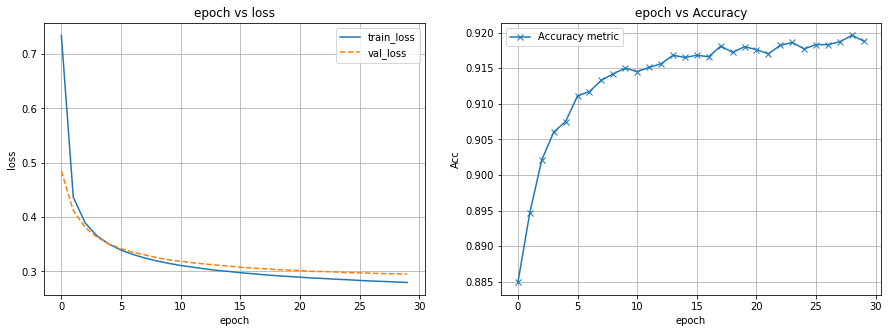

In [11]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()